<a href="https://colab.research.google.com/github/shazzad-hasan/tensorflow-projects/blob/main/tweet_emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will train a model to recognize tweet emotion using the huggingface [emotion](https://huggingface.co/datasets/emotion) dataset. Emotion is a dataset of English Twitter messages with six basic emotions: anger, fear, joy, love, sadness, and surprise. The process will be broken down into the following steps:

1.   Load and visualize the dataset
2.   Preprocess the dataset
3.   Define a neural network
4.   Define a loss function and optimizer
5.   Train and validate the model
6.   Evaluate the performance of the model on the test dataset



In [1]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# import required libraries

import numpy as np
import random
import matplotlib.pyplot as plt

%matplotlib inline

### Load and visualize dataset

In [3]:
import nlp

# load tweet emotion dataset from huggingface nlp module
dataset = nlp.load_dataset("emotion")

Using custom data configuration default


In [4]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [5]:
train_data = dataset['train']
valid_data = dataset['validation']
test_data = dataset['test']

In [6]:
# obtain tweets and labels from the data
def get_tweet(data):
  tweets = [x['text'] for x in data] # obtain tweets
  labels = [x['label'] for x in data] # obtain tweets labels
  return tweets, labels

# obtain training, validation and test  tweets, labels 
train_tweets, train_labels = get_tweet(train_data)
valid_tweets, valid_labels = get_tweet(valid_data)
test_tweets, test_labels = get_tweet(test_data)


# let's see first 10 tweets and corresponding labels
for i in range(10):
  print("({}, {})".format(train_tweets[i], train_labels[i]))

(i didnt feel humiliated, sadness)
(i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake, sadness)
(im grabbing a minute to post i feel greedy wrong, anger)
(i am ever feeling nostalgic about the fireplace i will know that it is still on the property, love)
(i am feeling grouchy, anger)
(ive been feeling a little burdened lately wasnt sure why that was, sadness)
(ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny, surprise)
(i feel as confused about life as a teenager or as jaded as a year old man, fear)
(i have been with petronas for years i feel that petronas has performed well and made a huge profit, joy)
(i feel romantic too, love)


### Pre-process the dataset

#### Prepare tweets

##### Tokenize the tweets

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer

# let's tokenize 10,000 most commonly used words
tokenizer = Tokenizer(num_words=1000, oov_token="UNK")
tokenizer.fit_on_texts(train_tweets)

In [8]:
# lets see the tokinization of a tweet
print("{} ---> {}".format(train_tweets[0], tokenizer.texts_to_sequences([train_tweets[0]])))

i didnt feel humiliated ---> [[2, 139, 3, 679]]


##### Padding and Truncating sequences

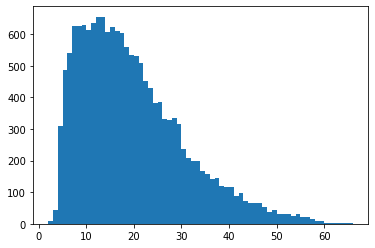

In [9]:
# check length of the tweets
lengths = [len(twt.split(" ")) for twt in train_tweets]
plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 50

def get_sequences(tokenizer, tweets):
  # tokenize tweets
  sequences = tokenizer.texts_to_sequences(tweets)
  # obtain padded and truncated sequences
  padded_seqs = pad_sequences(sequences, truncating="post", padding="post", maxlen=maxlen)
  return padded_seqs

In [11]:
# obtain padded and truncated training sequences
padded_train_seq = get_sequences(tokenizer, train_tweets)
padded_valid_seq = get_sequences(tokenizer, valid_tweets)
padded_test_seq = get_sequences(tokenizer, test_tweets)

print("{}, \n{}".format(train_tweets[0], padded_train_seq[0]))

i didnt feel humiliated, 
[  2 139   3 679   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


#### Prepare labels

In [12]:
classes = set(train_labels)
print(classes)

{'fear', 'joy', 'anger', 'surprise', 'love', 'sadness'}


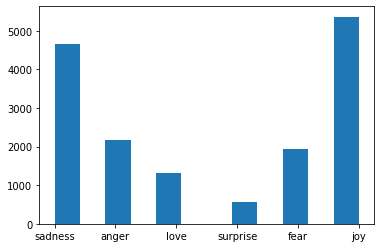

In [13]:
plt.hist(train_labels, bins=12)
plt.show()

In [14]:
class_to_idx = dict((c, i) for i, c in enumerate(classes))
idx_to_class = dict((v, k) for k, v in class_to_idx.items())

print(class_to_idx)
print(idx_to_class)

{'fear': 0, 'joy': 1, 'anger': 2, 'surprise': 3, 'love': 4, 'sadness': 5}
{0: 'fear', 1: 'joy', 2: 'anger', 3: 'surprise', 4: 'love', 5: 'sadness'}


In [15]:
names_to_ids = lambda labels: np.array([class_to_idx.get(x) for x in labels])

train_labels = names_to_ids(train_labels)
valid_labels = names_to_ids(valid_labels)
test_labels = names_to_ids(test_labels)

print(train_labels[0])

5


### Define a neural network

In [16]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.models.Sequential([
            layers.Embedding(10000, 16, input_length=maxlen),
            layers.Bidirectional(keras.layers.LSTM(20, return_sequences=True)),
            layers.Bidirectional(keras.layers.LSTM(20)),
            layers.Dense(6, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

callbacks=[keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2)]
history = model.fit(padded_train_seq, train_labels, 
                    validation_data=(padded_valid_seq, valid_labels),
                    epochs=20,
                    callbacks=callbacks)

Epoch 1/20
500/500 [==============================] - 13s 13ms/step - loss: 1.2992 - accuracy: 0.4851 - val_loss: 0.8450 - val_accuracy: 0.6820
Epoch 2/20
500/500 [==============================] - 5s 10ms/step - loss: 0.6555 - accuracy: 0.7711 - val_loss: 0.6053 - val_accuracy: 0.7915
Epoch 3/20
500/500 [==============================] - 5s 10ms/step - loss: 0.5066 - accuracy: 0.8231 - val_loss: 0.5384 - val_accuracy: 0.8090
Epoch 4/20
500/500 [==============================] - 5s 10ms/step - loss: 0.4328 - accuracy: 0.8523 - val_loss: 0.4819 - val_accuracy: 0.8335
Epoch 5/20
500/500 [==============================] - 5s 10ms/step - loss: 0.3808 - accuracy: 0.8659 - val_loss: 0.4349 - val_accuracy: 0.8560
Epoch 6/20
500/500 [==============================] - 5s 11ms/step - loss: 0.3482 - accuracy: 0.8752 - val_loss: 0.4132 - val_accuracy: 0.8550
Epoch 7/20
500/500 [==============================] - 5s 11ms/step - loss: 0.3222 - accuracy: 0.8814 - val_loss: 0.4129 - val_accuracy: 0.852

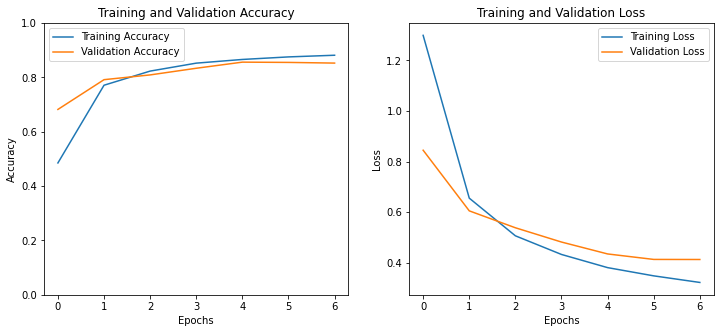

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = 20
epochs_range = range(0, len(acc))

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim([0,1])
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

### Evaluate the model on the test dataset

In [19]:
test_loss, test_acc = model.evaluate(padded_test_seq, test_labels)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

63/63 [==============================] - 0s 5ms/step - loss: 0.4065 - accuracy: 0.8595
Test Loss: 0.4064711332321167
Test Accuracy: 0.859499990940094


In [20]:
i = random.randint(0, len(test_labels)-1)

print("Sentence: ", test_tweets[i])
print("Emotion: ", idx_to_class[test_labels[i]])

p = model.predict(np.expand_dims(padded_test_seq[i], axis=0))[0]
pred_class = idx_to_class[np.argmax(p).astype("uint8")]
print("Predicted Emotion: ", pred_class)

Sentence:  i know that you feel pretty disgusted by the nonstop lefty propaganda the ministry churns out but of the public isn t that tuned in
Emotion:  anger
Predicted Emotion:  anger
